In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cora-dataset/cora/README
/kaggle/input/cora-dataset/cora/cora.cites
/kaggle/input/cora-dataset/cora/cora.content


In [2]:
import os
import urllib.request
import numpy as np
import pandas as pd
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score
import torch.nn.functional as F
import random
from sklearn.preprocessing import LabelEncoder
import time
from tqdm import tqdm

Adjacency Matrix shape: torch.Size([2708, 2708])
Features shape: torch.Size([2708, 1433])
Labels shape: torch.Size([2708])
Number of Nodes: 2708
Number of Edges: 5278


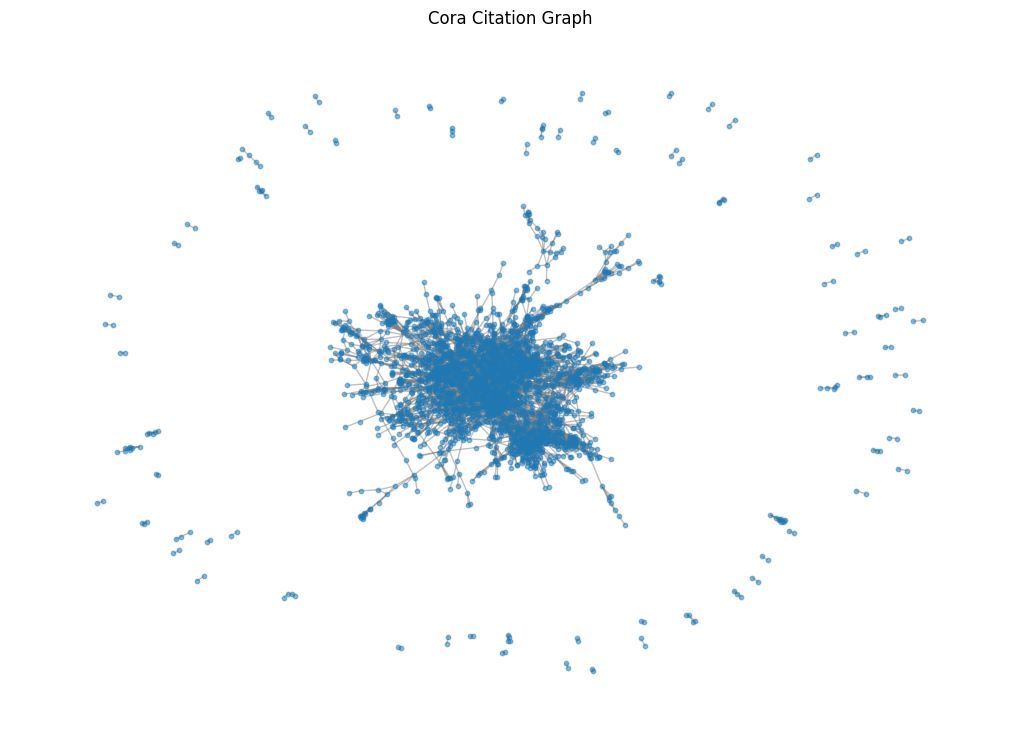

Train features shape: torch.Size([2166, 1433])
Train labels shape: torch.Size([2166])
Test features shape: torch.Size([542, 1433])
Test labels shape: torch.Size([542])


In [3]:
def load_cora_dataset(path="cora/"):
    """
    Loads the Cora dataset from the specified path.

    Args:
        path (str): The path to the Cora dataset directory.

    Returns:
        tuple: A tuple containing the adjacency matrix, node features, and node labels.
    """

    # Load node features and labels
    content_path = os.path.join(path, "cora.content")
    content_df = pd.read_csv(content_path, sep='\t', header=None)

    # Extract node IDs, features, and labels
    node_ids = content_df.iloc[:, 0].tolist()
    features = content_df.iloc[:, 1:-1].values.astype(np.float32)  # Explicitly convert to float32
    labels = content_df.iloc[:, -1].tolist()

    # Create a mapping from node IDs to indices
    node_to_idx = {node_id: idx for idx, node_id in enumerate(node_ids)}

    # Load edges
    cites_path = os.path.join(path, "cora.cites")
    cites_df = pd.read_csv(cites_path, sep='\t', header=None)

    # Create an adjacency matrix
    num_nodes = len(node_ids)
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float32) #use float32

    # Populate the adjacency matrix
    for _, row in cites_df.iterrows():
        source_id = row[0]
        target_id = row[1]
        if source_id in node_to_idx and target_id in node_to_idx:
            source_idx = node_to_idx[source_id]
            target_idx = node_to_idx[target_id]
            adjacency_matrix[source_idx, target_idx] = 1
            adjacency_matrix[target_idx, source_idx] = 1  # Cora is undirected

    # Encode labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    return adjacency_matrix, features, encoded_labels

def create_networkx_graph(adjacency_matrix):
    """
    Creates a NetworkX graph from an adjacency matrix.

    Args:
        adjacency_matrix (numpy.ndarray): The adjacency matrix.

    Returns:
        networkx.Graph: The NetworkX graph.
    """
    graph = nx.from_numpy_array(adjacency_matrix)
    return graph

def preprocess_cora(path="cora/", test_size=0.2, random_state=42):
    """
    Combines the loading and preprocessing of the Cora dataset.

    Args:
        path (str): The path to the Cora dataset directory.
        test_size (float): The proportion of the dataset to include in the test split.
        random_state (int): Controls the shuffling applied to the data before applying the split.

    Returns:
        tuple: A tuple containing the adjacency matrix, node features, encoded labels, and networkx graph.
    """
    adjacency_matrix, features, encoded_labels = load_cora_dataset(path)
    graph = create_networkx_graph(adjacency_matrix)

    # Split train/test data
    train_idx, test_idx = train_test_split(np.arange(len(encoded_labels)), test_size=test_size, random_state=random_state)

    return adjacency_matrix, features, encoded_labels, graph, train_idx, test_idx

def plot_graph(G):
    """
    Plots the NetworkX graph.
    """
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, node_size=10, with_labels=False, edge_color="gray", alpha=0.5)
    plt.title("Cora Citation Graph")
    plt.show()

# Example usage:
DATASET_PATH = "/kaggle/input/cora-dataset/cora/"
adjacency_matrix, features, encoded_labels, graph, train_idx, test_idx = preprocess_cora(DATASET_PATH)

# Convert to torch tensors
adjacency_tensor = torch.tensor(adjacency_matrix, dtype=torch.float32)
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(encoded_labels, dtype=torch.long)

print("Adjacency Matrix shape:", adjacency_tensor.shape)
print("Features shape:", features_tensor.shape)
print("Labels shape:", labels_tensor.shape)
print("Number of Nodes:", graph.number_of_nodes())
print("Number of Edges:", graph.number_of_edges())

plot_graph(graph) #plot the graph

#Example of access the train and test data.
train_features = features_tensor[train_idx]
train_labels = labels_tensor[train_idx]
test_features = features_tensor[test_idx]
test_labels = labels_tensor[test_idx]

print(f"Train features shape: {train_features.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Test labels shape: {test_labels.shape}")

In [4]:
class GCN(nn.Module):
    def __init__(self, adjacency_matrix, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout=0.5):
        super(GCN, self).__init__()
        self.adjacency_matrix = adjacency_matrix.to(torch.float32)  # Ensure correct type
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.output_dim = output_dim
        self.dropout = dropout
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)

    def normalize_adjacency(self):
        device = self.adjacency_matrix.device
        adj = self.adjacency_matrix + torch.eye(self.adjacency_matrix.shape[0], device=device)
        degree = torch.sum(adj, dim=1)
        degree_inv_sqrt = torch.pow(degree, -0.5)
        degree_inv_sqrt[degree_inv_sqrt == float('inf')] = 0
        degree_matrix_inv_sqrt = torch.diag(degree_inv_sqrt)
        return degree_matrix_inv_sqrt @ adj @ degree_matrix_inv_sqrt

    def forward(self, features):
        normalized_adj = self.normalize_adjacency().to(features.device) 

        x = torch.matmul(normalized_adj, features)
        x = F.relu(self.layer1(x))
        x = F.dropout(x, self.dropout, training=self.training)

        x = torch.matmul(normalized_adj, x)
        x = F.relu(self.layer2(x))
        x = F.dropout(x, self.dropout, training=self.training)

        x = torch.matmul(normalized_adj, x)
        x = self.layer3(x)

        return x  

    def get_embeddings(self, features):
        normalized_adj = self.normalize_adjacency()

        x = torch.matmul(normalized_adj, features)
        x = F.relu(self.layer1(x))
        x = F.dropout(x, self.dropout, training=self.training)

        x = torch.matmul(normalized_adj, x)
        x = F.relu(self.layer2(x))
        x = F.dropout(x, self.dropout, training=self.training)

        return x.detach().cpu().numpy()  # Convert to NumPy safely


In [5]:
class DeepWalk(nn.Module):
    def __init__(self, graph, embedding_dim, walk_length, num_walks, window_size=5):
        super(DeepWalk, self).__init__()
        self.graph = graph
        self.embedding_dim = embedding_dim
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.window_size = window_size

        self.nodes = list(graph.nodes())
        self.node_to_idx = {node: i for i, node in enumerate(self.nodes)}
        self.idx_to_node = {i: node for node, i in self.node_to_idx.items()}

        self.embeddings = nn.Embedding(len(self.nodes), embedding_dim)
        self.context_embeddings = nn.Embedding(len(self.nodes), embedding_dim)

        # Move model to device (GPU if available)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def generate_walk(self, start_node, seed=None):
        if seed is not None:
            random.seed(seed)  # Set seed for reproducibility
        walk = [start_node]
        for _ in range(self.walk_length - 1):
            neighbors = list(self.graph.neighbors(walk[-1]))
            if not neighbors:
                break
            next_node = random.choice(neighbors)
            walk.append(next_node)
        return walk

    def generate_walks(self):
        walks = []
        for _ in range(self.num_walks):
            random.shuffle(self.nodes)  # Ensures randomness
            for node in self.nodes:
                walks.append(self.generate_walk(node))
        return walks

    def forward(self, target_node_idx, context_node_idx):
        target_embed = self.embeddings(target_node_idx)
        context_embed = self.context_embeddings(context_node_idx)
        score = torch.matmul(target_embed, context_embed.T).squeeze()  # More efficient
        return torch.sigmoid(score)

    def train_model(self, epochs, learning_rate):
        walks = self.generate_walks()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        loss_function = nn.BCELoss()
        losses = []

        for epoch in tqdm(range(epochs), desc="DeepWalk Training", unit="epoch"):
            total_loss = 0

            for walk in walks:
                for i, target_node in enumerate(walk):
                    target_idx = self.node_to_idx[target_node]
                    context = walk[max(0, i - self.window_size):i] + walk[i + 1:i + self.window_size + 1]

                    for context_node in context:
                        if context_node in self.node_to_idx:
                            context_idx = self.node_to_idx[context_node]

                            # Convert tensors to device (CPU/GPU)
                            target_tensor = torch.tensor([target_idx], device=self.device)
                            context_tensor = torch.tensor([context_idx], device=self.device)

                            positive_score = self.forward(target_tensor, context_tensor)
                            positive_label = torch.ones_like(positive_score)

                            loss = loss_function(positive_score, positive_label)

                            # Negative Sampling
                            negative_idx = torch.randint(0, len(self.nodes), (1,), device=self.device)
                            negative_tensor = negative_idx

                            negative_score = self.forward(target_tensor, negative_tensor)
                            negative_label = torch.zeros_like(negative_score)

                            loss += loss_function(negative_score, negative_label)

                            optimizer.zero_grad()
                            loss.backward()
                            optimizer.step()

                            total_loss += loss.item()
                            

            print(f"Epoch {epoch+1}, Loss: {total_loss / len(walks)}")
            losses.append(total_loss / len(walks))
        return losses

    def get_embeddings(self):
        return self.embeddings.weight.detach().cpu().numpy()  # Ensure compatibility with GPU


In [6]:
class GAT(nn.Module):
    def __init__(self, adjacency_matrix, input_dim, hidden_dim1, hidden_dim2, output_dim, 
                 alpha=0.2, dropout=0.6, nheads=8):
        super(GAT, self).__init__()
        self.register_buffer('adjacency_matrix', self.process_adj(adjacency_matrix))
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.output_dim = output_dim
        self.alpha = alpha
        self.dropout = dropout
        self.nheads = nheads

        # First multi-head attention layer
        self.W1 = nn.Linear(input_dim, hidden_dim1 * nheads)
        self.a1 = nn.Parameter(torch.empty(nheads, 2 * hidden_dim1))
        
        # Second multi-head attention layer
        self.W2 = nn.Linear(hidden_dim1 * nheads, hidden_dim2 * nheads)
        self.a2 = nn.Parameter(torch.empty(nheads, 2 * hidden_dim2))
        
        # Output layer
        self.out = nn.Linear(hidden_dim2 * nheads, output_dim)

        self.init_parameters()

    def process_adj(self, adj):
        """Add self-loops and ensure proper format"""
        adj = adj.clone().to(torch.float32)
        idx = torch.arange(adj.size(0), device=adj.device)
        adj[idx, idx] = 1.0  # Add self-loops
        return adj

    def init_parameters(self):
        """Xavier initialization for all parameters"""
        nn.init.xavier_uniform_(self.W1.weight)
        nn.init.xavier_uniform_(self.W2.weight)
        nn.init.xavier_uniform_(self.out.weight)
        nn.init.xavier_uniform_(self.a1)
        nn.init.xavier_uniform_(self.a2)

    def forward(self, x):
        # Layer 1: Multi-head attention
        x = F.dropout(x, self.dropout, training=self.training)
        h1 = self.attention_layer(x, self.W1, self.a1, self.hidden_dim1)
        h1 = F.elu(h1)
        
        # Layer 2: Multi-head attention
        h1 = F.dropout(h1, self.dropout, training=self.training)
        h2 = self.attention_layer(h1, self.W2, self.a2, self.hidden_dim2)
        h2 = F.elu(h2)  # Remove for classification tasks
        
        # Output layer
        return self.out(h2)

    def attention_energy(self, Wh, a):
        """Compute attention energy scores with proper dimension alignment"""
        # Wh shape: [N, nheads, hidden_dim]
        # Create all (i,j) node pairs for each head:
        # Wh_i: [N, N, nheads, hidden_dim] and Wh_j: [N, N, nheads, hidden_dim]
        N, nheads, hidden_dim = Wh.size()
        Wh_i = Wh.unsqueeze(1).expand(N, N, nheads, hidden_dim)
        Wh_j = Wh.unsqueeze(0).expand(N, N, nheads, hidden_dim)
        
        # Concatenate features for energy calculation: [N, N, nheads, 2*hidden_dim]
        combined = torch.cat([Wh_i, Wh_j], dim=-1)
        
        # Compute energy per head:
        return torch.einsum('ijhd,hd->ijh', combined, a)

    def attention_layer(self, x, W, a, hidden_dim):
        """Fixed attention layer with proper dimension handling"""
        N = x.size(0)
        Wh = W(x).view(N, self.nheads, hidden_dim)  # [N, nheads, hidden_dim]
    
        # Compute attention scores
        energy = self.attention_energy(Wh, a)
        energy = F.leaky_relu(energy, self.alpha)
    
        # Apply adjacency mask: convert to bool mask
        mask = self.adjacency_matrix.bool().unsqueeze(-1)  # [N, N, 1]
        energy = energy.masked_fill(~mask, -1e9)
    
        # Normalize and apply dropout over neighbor dimension (dim=1)
        attention = F.softmax(energy, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
    
        # Aggregate features: for each node i and head h, sum over all j nodes
        h_prime = torch.einsum('ijh,jhd->ihd', attention, Wh)  # [N, nheads, hidden_dim]
        return h_prime.reshape(N, -1)  # Flatten heads

    def get_embeddings(self, x):
        """Get node embeddings with disabled dropout and gradients"""
        self.eval()
        with torch.no_grad():
            h1 = self.attention_layer(x, self.W1, self.a1, self.hidden_dim1)
            h2 = self.attention_layer(h1, self.W2, self.a2, self.hidden_dim2)
            return h2.cpu().numpy()


In [7]:
def train_and_evaluate(model, features, labels, train_idx, test_idx, epochs, learning_rate, deepwalk=False, adjacency_matrix=None):
    # Set device and move all tensors to it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    features = features.to(device)
    labels = labels.to(device)
    
    # Ensure indices are tensors on the correct device
    train_idx = torch.as_tensor(train_idx, device=device)
    test_idx = torch.as_tensor(test_idx, device=device)
    
    # Handle DeepWalk separately
    if deepwalk:
        print("DeepWalk mode selected. Returning embeddings for downstream classification.")
        embeddings = model.get_embeddings()
        return embeddings, None, None, None, None

    # Define loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    
    # Training loop
    for epoch in tqdm(range(epochs), desc="Model Training", unit="epoch"):
        model.train()
        optimizer.zero_grad()
        outputs = model(features)
        loss = loss_function(outputs[train_idx], labels[train_idx])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if epoch > 0 and epoch % max(1, epochs // 10) == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # Evaluation
    model.eval()
    start_time = time.perf_counter()
    with torch.no_grad():
        outputs = model(features)
    end_time = time.perf_counter()
    
    inference_time = end_time - start_time
    _, predicted = torch.max(outputs[test_idx], 1)
    
    # Compute metrics
    y_true = labels[test_idx].cpu().numpy()
    y_pred = predicted.cpu().numpy()
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    
    print(f'F1 Macro: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision Macro: {precision}')
    print(f'Inference Time: {inference_time:.6f} seconds')
    
    return losses, f1, accuracy, precision, inference_time


In [8]:
DATASET_PATH = "/kaggle/input/cora-dataset/cora/"
adjacency_matrix, features, encoded_labels, graph, train_idx, test_idx = preprocess_cora(DATASET_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

adjacency_tensor = torch.tensor(adjacency_matrix, dtype=torch.float32, device=device)
features_tensor = torch.tensor(features, dtype=torch.float32, device=device)
labels_tensor = torch.tensor(encoded_labels, dtype=torch.long, device=device)

In [9]:
# Define a downstream classifier that takes DeepWalk embeddings as input
class DeepWalkClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(DeepWalkClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    def forward(self, x):
        return self.linear(x)


# 4. Train the DeepWalk downstream classifier using a modified train_and_evaluate
def train_and_evaluate_classifier(model, features, labels, train_idx, test_idx, epochs, learning_rate):
    model.to(device)
    features = features.to(device)
    labels = labels.to(device)
    if not torch.is_tensor(train_idx):
        train_idx = torch.tensor(train_idx, device=device)
    else:
        train_idx = train_idx.to(device)
    if not torch.is_tensor(test_idx):
        test_idx = torch.tensor(test_idx, device=device)
    else:
        test_idx = test_idx.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    losses = []
    
    for epoch in tqdm(range(epochs), desc="Classifier Training", unit="epoch"):
        model.train()
        optimizer.zero_grad()
        outputs = model(features)
        loss = loss_function(outputs[train_idx], labels[train_idx])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch > 0 and epoch % max(1, epochs // 10) == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    model.eval()
    start_time = time.perf_counter()
    outputs = model(features)
    end_time = time.perf_counter()
    inference_time = end_time - start_time

    _, predicted = torch.max(outputs[test_idx], 1)
    y_true = labels[test_idx].cpu().numpy()
    y_pred = predicted.cpu().numpy()
    
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    
    print(f'F1 Macro: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision Macro: {precision}')
    print(f'Inference Time: {inference_time} seconds')
    
    return losses, f1, accuracy, precision, inference_time

In [10]:
# # 1. Train DeepWalk model (unsupervised embedding training)
# deepwalk_model = DeepWalk(graph, embedding_dim=12, walk_length=3, num_walks=10)
# deepwalk_model.train_model(epochs=10, learning_rate=0.01)
# # 2. Extract embeddings
# deepwalk_embeddings_np = deepwalk_model.get_embeddings()  # shape: [num_nodes, embedding_dim]
# deepwalk_embeddings = torch.tensor(deepwalk_embeddings_np, dtype=torch.float32, device=device)



# deepwalk_classifier = DeepWalkClassifier(input_dim=deepwalk_embeddings.shape[1], 
#                                          num_classes=len(torch.unique(labels_tensor)))
# deepwalk_classifier.to(device)


# print("Training DeepWalk classifier:")
# deepwalk_losses, deepwalk_f1, deepwalk_acc, deepwalk_prec, deepwalk_inf_time = train_and_evaluate_classifier(
#     deepwalk_classifier, deepwalk_embeddings, labels_tensor, train_idx, test_idx, epochs=200, learning_rate=0.01)


In [11]:
# # ---------------------------
# # GCN Training & Evaluation
# # ---------------------------
# adjacency_tensor = torch.tensor(adjacency_matrix, dtype=torch.float32)
# gcn_model = GCN(adjacency_tensor, input_dim=features_tensor.shape[1], hidden_dim1=64, hidden_dim2=32,
#                output_dim=len(torch.unique(labels_tensor)))
# gcn_losses, gcn_f1, gcn_acc, gcn_prec, gcn_inf_time = train_and_evaluate(
#     gcn_model, features_tensor, labels_tensor, train_idx, test_idx, epochs=200, learning_rate=0.01, adjacency_matrix=adjacency_tensor)


In [12]:
# # ---------------------------
# # GAT Training & Evaluation
# # ---------------------------
# adjacency_tensor = torch.tensor(adjacency_matrix, dtype=torch.float32)
# gat_model = GAT(adjacency_tensor, input_dim=features_tensor.shape[1], hidden_dim1=16, hidden_dim2=8,nheads=4,
#                 output_dim=len(torch.unique(labels_tensor)))
# gat_losses, gat_f1, gat_acc, gat_prec, gat_inf_time = train_and_evaluate(
#     gat_model, features_tensor, labels_tensor, train_idx, test_idx, epochs=200, learning_rate=0.01, adjacency_matrix=adjacency_tensor)

In [13]:
# # ---------------------------
# # Plot Training Losses
# # ---------------------------
# plt.figure(figsize=(10, 5))
# plt.plot(deepwalk_losses, label='DeepWalk Classifier')
# plt.plot(gcn_losses, label='GCN')
# plt.plot(gat_losses, label='GAT')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Losses')
# plt.legend()
# plt.savefig("cora_models.png")  # Saves as PNG
# plt.show()

# # ---------------------------
# # Print Metrics
# # ---------------------------
# print("DeepWalk Classifier Metrics:")
# print(f"F1: {deepwalk_f1}, Accuracy: {deepwalk_acc}, Precision: {deepwalk_prec}, Inference Time: {deepwalk_inf_time}")
# print("GCN Metrics:")
# print(f"F1: {gcn_f1}, Accuracy: {gcn_acc}, Precision: {gcn_prec}, Inference Time: {gcn_inf_time}")
# print("GAT Metrics:")
# print(f"F1: {gat_f1}, Accuracy: {gat_acc}, Precision: {gat_prec}, Inference Time: {gat_inf_time}")

# Deep walk: Hyper-parameters analysis

In [ ]:
results_losses = []
results_f1 = []
walk_losses = []
# parameters for studies
emb_dim = [25, 50, 75, 100, 200]
walk_len = [3, 4, 6, 8, 10]
num_wal = [3, 4, 6, 8, 10]
learning_r = [0.05, 0.01, 0.0075, 0.005, 0.001]


for i in range(len(walk_len)):
    # 1. Train DeepWalk model (unsupervised embedding training)
    deepwalk_model = DeepWalk(graph, embedding_dim=50, walk_length=walk_len[i], num_walks=5)
    walk_losses.append(deepwalk_model.train_model(epochs=5, learning_rate=0.0075))
    # 2. Extract embeddings
    deepwalk_embeddings_np = deepwalk_model.get_embeddings()  # shape: [num_nodes, embedding_dim]
    deepwalk_embeddings = torch.tensor(deepwalk_embeddings_np, dtype=torch.float32, device=device)



    deepwalk_classifier = DeepWalkClassifier(input_dim=deepwalk_embeddings.shape[1], 
                                         num_classes=len(torch.unique(labels_tensor)))
    deepwalk_classifier.to(device)


    print("Training DeepWalk classifier:")
    deepwalk_losses, deepwalk_f1, deepwalk_acc, deepwalk_prec, deepwalk_inf_time = train_and_evaluate_classifier(
        deepwalk_classifier, deepwalk_embeddings, labels_tensor, train_idx, test_idx, epochs=100, learning_rate=0.01)

    results_losses.append(deepwalk_losses)
    results_f1.append(deepwalk_f1)


DeepWalk Training:  20%|██        | 1/5 [02:35<10:20, 155.21s/epoch]

Epoch 1, Loss: 32.60061158674902


DeepWalk Training:  40%|████      | 2/5 [05:09<07:43, 154.42s/epoch]

Epoch 2, Loss: 30.550888684401453


DeepWalk Training:  60%|██████    | 3/5 [07:41<05:07, 153.69s/epoch]

Epoch 3, Loss: 15.720645501589665


DeepWalk Training:  80%|████████  | 4/5 [10:14<02:33, 153.36s/epoch]

Epoch 4, Loss: 10.612413866030003


DeepWalk Training: 100%|██████████| 5/5 [12:48<00:00, 153.70s/epoch]


Epoch 5, Loss: 7.832237642933096
Training DeepWalk classifier:


Classifier Training: 100%|██████████| 100/100 [00:00<00:00, 210.55epoch/s]


Epoch 10, Loss: 1.501363754272461
Epoch 20, Loss: 1.2720342874526978
Epoch 30, Loss: 1.2124862670898438
Epoch 40, Loss: 1.1935150623321533
Epoch 50, Loss: 1.1851218938827515
Epoch 60, Loss: 1.1813609600067139
Epoch 70, Loss: 1.1797538995742798
Epoch 80, Loss: 1.17898428440094
Epoch 90, Loss: 1.1785557270050049
F1 Macro: 0.47023542855557465
Accuracy: 0.5055350553505535
Precision Macro: 0.49163024972842984
Inference Time: 0.0007278789998963475 seconds


DeepWalk Training:  20%|██        | 1/5 [05:08<20:35, 308.86s/epoch]

Epoch 1, Loss: 57.99718694001887


DeepWalk Training:  40%|████      | 2/5 [10:15<15:22, 307.46s/epoch]

Epoch 2, Loss: 27.98988183449497


DeepWalk Training:  60%|██████    | 3/5 [15:21<10:13, 306.96s/epoch]

Epoch 3, Loss: 22.25427356468373


DeepWalk Training:  80%|████████  | 4/5 [20:26<05:06, 306.12s/epoch]

Epoch 4, Loss: 21.18743505239226


DeepWalk Training: 100%|██████████| 5/5 [25:32<00:00, 306.44s/epoch]


Epoch 5, Loss: 21.135802764870693
Training DeepWalk classifier:


Classifier Training: 100%|██████████| 100/100 [00:00<00:00, 841.96epoch/s]

Epoch 10, Loss: 1.2181826829910278
Epoch 20, Loss: 0.9766562581062317
Epoch 30, Loss: 0.9082583785057068
Epoch 40, Loss: 0.8784764409065247
Epoch 50, Loss: 0.863764226436615
Epoch 60, Loss: 0.8569867014884949
Epoch 70, Loss: 0.8538481593132019
Epoch 80, Loss: 0.8522360920906067
Epoch 90, Loss: 0.8513393998146057
F1 Macro: 0.6640827696334742
Accuracy: 0.6900369003690037
Precision Macro: 0.6737444208811204
Inference Time: 0.0003052539996133419 seconds



DeepWalk Training:  20%|██        | 1/5 [12:46<51:07, 766.81s/epoch]

Epoch 1, Loss: 104.85466329528155


DeepWalk Training:  40%|████      | 2/5 [25:31<38:17, 765.70s/epoch]

Epoch 2, Loss: 82.98452846888954


DeepWalk Training:  60%|██████    | 3/5 [38:18<25:32, 766.40s/epoch]

Epoch 3, Loss: 96.94406114870694


DeepWalk Training:  80%|████████  | 4/5 [51:07<12:47, 767.23s/epoch]

Epoch 4, Loss: 103.81390135789255


In [ ]:
# ---------------------------
# Plot Training Losses
# ---------------------------
plt.figure(figsize=(10, 5))

for i, losses in enumerate(results_losses):
    plt.plot(losses, label=f'walking len={walk_len[i]}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses for Different Walking Length')
plt.legend()
plt.savefig("deep_walk_wal_len.png")  # Saves as PNG
plt.grid()
plt.show()

# Print F1 scores for each learning rate
print("F1 Scores per Learning Rate:", results_f1)

In [ ]:
plt.figure(figsize=(10, 5))

# Iterate over each embedding dimension's loss history
for i, losses in enumerate(walk_losses):
    plt.plot(losses, label=f'walking Len={walk_len[i]}', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Walking Losses for Different Walking Length')
plt.legend()
plt.savefig("walk_wal_len.png")  # Saves as PNG
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(walk_len, results_f1, marker='o', linestyle='-')  # Use full list
plt.xlabel('Walking Length')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different Walking Length')
plt.legend(["DeepWalk"])
plt.savefig("f1_walk_wal_len.png")  # Saves as PNG
plt.grid()
plt.show()